###  Подключение к ClickHouse через Python c использованием библиотеки pandahouse

Датасет, содержит информацию об объявлениях на Airbnb в Лондоне 🇬🇧.

ldn_listings – информация о жилье, включая полные описания, характеристики и средние оценки в отзывах и т.д

In [2]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# настройка графиков
sns.set(
font_scale=2,
style = "whitegrid",
rc = {'figure.figsize':(20,7)})

In [4]:
# настраиваем коннект с ClickHouse  (connection_default)
connection_default = {'host': 'https://clickhouse.lab.karpov.courses/',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Проверим правильность подключения к ClickHouse через pandahouse, написав простой запрос SQL, 
подсчета количество строк в таблице выведите количество строк в таблице

In [5]:
query = """
SELECT count() AS count_rows
FROM default.ldn_listings
"""
df_1 = ph.read_clickhouse(query, connection=connection_default)
df_1

,count_rows
0,85207


Напишем запрос SQL для выгрузки данных (price – цена за ночь, room_type – тип сдаваемого жилья) и загрузим данные в датафрейм

In [6]:
query = """
SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
ORDER BY
id ASC
LIMIT 1000
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


In [7]:
# Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены т.е 75% значений меньше 70 и 25% больше 70
df[df.room_type== 'Private room'].quantile(q=0.75) 

price    70.0
Name: 0.75, dtype: float64

Напишем запрос SQL, выгрузим данным о цене, типе комнаты и рейтинге жилья (review_scores_rating). В запросе отфильтруем пустые значения и запишем данные в датафрейм

In [9]:
query = """
SELECT 
room_type, 
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, 
toFloat32OrNull(review_scores_rating) AS review_scores_rating
FROM ldn_listings
WHERE review_scores_rating IS NOT NULL
ORDER BY
id ASC
LIMIT 1000
"""
df_2 = ph.read_clickhouse(query, connection=connection_default)
df_2

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [10]:
# сгруппируем данные по типу комнат и найдем среднее значения
df_mean = df_2.groupby('room_type', as_index=False) \
.agg({'price':'mean', 'review_scores_rating':'mean'}) \
.rename(columns={'price': 'mean_price', 'review_scores_rating': 'mean_review_scores'})

In [11]:
df_mean

,room_type,mean_price,mean_review_scores
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


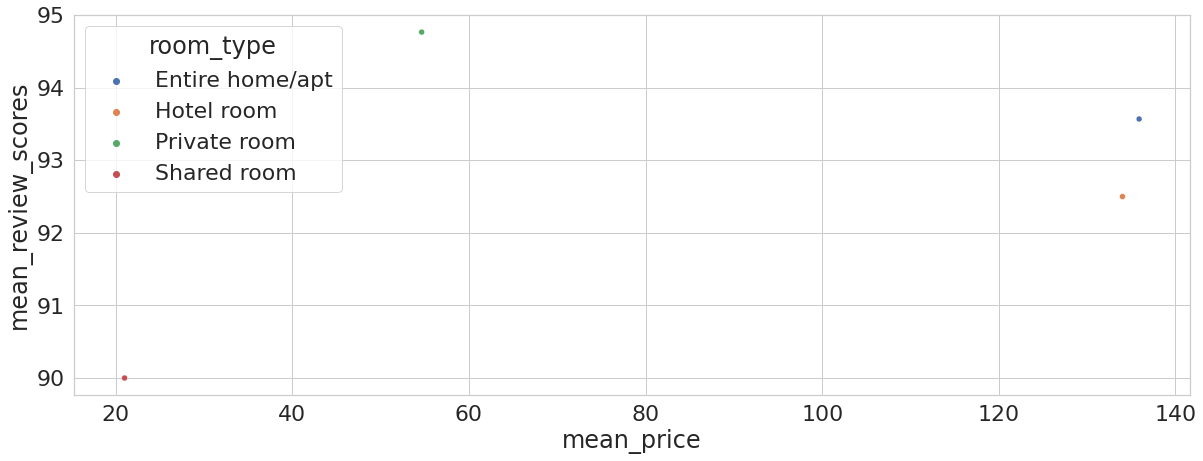

In [12]:
# построим плот, х - средняя цена, у - средняя цена, хуе(категории) - тип комнат
ax = sns.scatterplot(data=df_mean, x='mean_price', y='mean_review_scores', hue='room_type')

In [14]:
query = """
SELECT 
DISTINCT host_id, 
host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_3 = ph.read_clickhouse(query, connection=connection_default)
df_3

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [15]:
df_3.host_verifications = df_3.host_verifications.apply(lambda x: x.split(','))

In [16]:
df_3

,host_id,host_verifications
0,54730,"[['email', 'phone', 'facebook', 'reviews', ..."
1,60302,"[['email', 'phone', 'reviews', 'jumio', 'g..."
2,67915,"[['email', 'phone', 'jumio', 'selfie', 'go..."
3,167107,"[['email', 'phone', 'manual_offline', 'jumi..."
4,103583,"[['email', 'phone', 'reviews', 'offline_gov..."
...,...,...
1356,21558962,"[['email', 'phone', 'reviews', 'jumio', 'g..."
1357,21257846,"[['email', 'phone', 'reviews', 'jumio', 'o..."
1358,34219613,"[['email', 'phone', 'reviews', 'jumio', 'g..."
1359,34299581,"[['email', 'phone', 'google', 'reviews', '..."


In [17]:
# считаем, сколько раз встречается каждый способ верификации
df_3.explode('host_verifications').value_counts('host_verifications')

host_verifications
['email'                    1345
 'phone'                    1322
 'reviews'                  1201
 'jumio'                    1114
 'government_id']            755
 'offline_government_id'     469
 'government_id'             441
 'work_email']               279
 'facebook'                  266
 'selfie'                    251
 'identity_manual']          181
 'reviews']                  108
 'manual_offline'             68
 'identity_manual'            46
 'google'                     34
 'phone']                     23
 'kba'                        23
['phone'                      16
 'manual_online'              16
 'kba']                        4
 'facebook']                   4
 'sent_id'                     3
 'sent_id']                    3
 'manual_offline']             2
 'jumio']                      1
 'selfie']                     1
dtype: int64

Напишем SQL запрос: сгруппируем данные по району и виду впечатления и посчитаем количество объявлений (experiences_count), отсортируем данные по убыванию experiences_count и выгрузим первые 100 строк

In [18]:
query = """
SELECT
neighbourhood_cleansed, 
experiences_offered,
count() AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY
neighbourhood_cleansed,
experiences_offered
ORDER BY
experiences_count DESC
LIMIT 100
"""
df_4 = ph.read_clickhouse(query, connection=connection_default)
df_4

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [21]:
# преобразуем данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района
df_5 = df_4.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values ='experiences_count')

In [22]:
df_5

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,NaN,NaN,NaN,2.0
Barnet,7.0,7.0,3.0,5.0
Bexley,1.0,NaN,NaN,NaN
Brent,9.0,21.0,5.0,6.0
Bromley,3.0,2.0,NaN,4.0
Camden,36.0,30.0,19.0,25.0
City of London,7.0,1.0,NaN,NaN
Croydon,2.0,3.0,NaN,4.0
Ealing,6.0,13.0,NaN,5.0


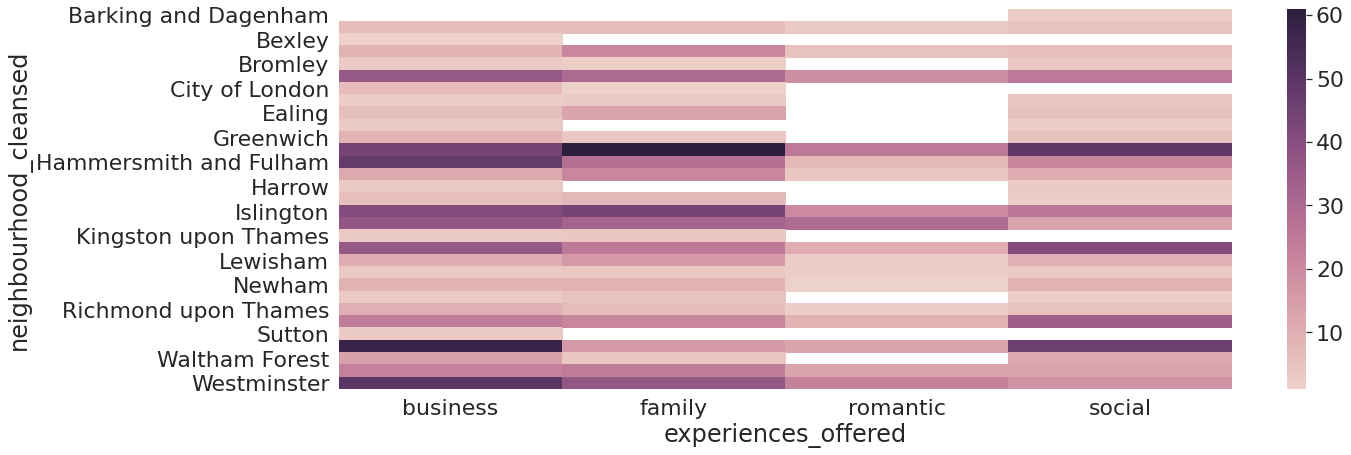

In [24]:
# Визуализируем результат с помощью sns.heatmap()
ax1 = sns.heatmap(df_5, cmap=sns.cubehelix_palette(as_cmap=True))

Пишем SQL запрос, выгружаем данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления, записываем в датафрейм

In [25]:
query = """
SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""
df_6 = ph.read_clickhouse(query, connection=connection_default)
df_6

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


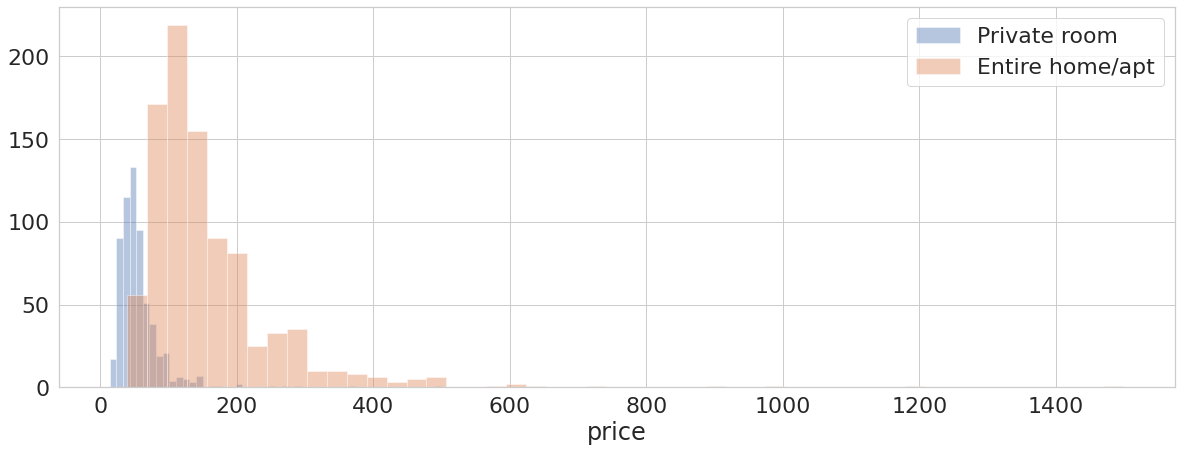

In [26]:
# визуализируем данные: исходные распределения цен для каждого типа жилья
sns.distplot(df_6.query("room_type=='Private room'").price, kde=False, label='Private room')
sns.distplot(df_6.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
plt.legend()
plt.show()

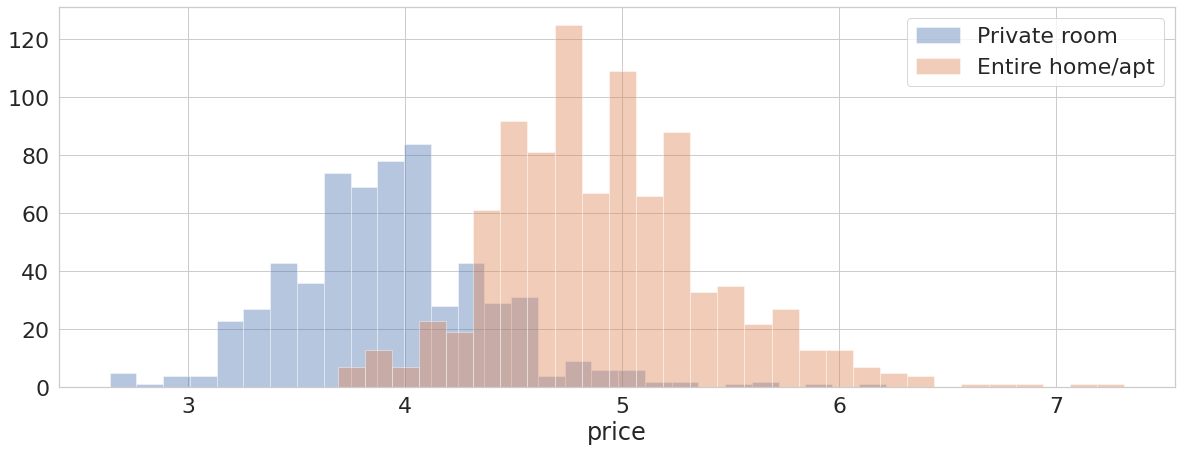

In [27]:
# визуализируем данные: исходные распределения цен для каждого типа жилья, логарифмированные значения (np.log())
sns.distplot(np.log(df_6.query("room_type=='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(df_6.query("room_type=='Entire home/apt'").price), kde=False, label='Entire home/apt')
plt.legend()
plt.show()

Напишем SQL запрос, выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года, запишем в датафрейм

In [30]:
query = """
SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
LIMIT 1000
"""
df_7 = ph.read_clickhouse(query, connection=connection_default)
df_7

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [31]:
# оставим только значения года первого отзыва
df_7.first_review = df_7.first_review.apply(lambda x: x.split('-')[0])

In [32]:
df_7

,room_type,price,first_review
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


In [34]:
# сгруппируем данные по типу желья и году первого отзыва, посчитаем среднюю цену
df_8 = df_7.groupby(['room_type', 'first_review'], as_index=False).agg({'price':'mean'})

In [35]:
df_8 = df_8.sort_values('first_review')

In [36]:
df_8

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
13,Private room,2010,56.428570
11,Hotel room,2010,88.000000
1,Entire home/apt,2011,128.792450
14,Private room,2011,52.607143
2,Entire home/apt,2012,135.467255
15,Private room,2012,53.269840
24,Shared room,2012,22.000000
3,Entire home/apt,2013,137.887634
16,Private room,2013,57.036587


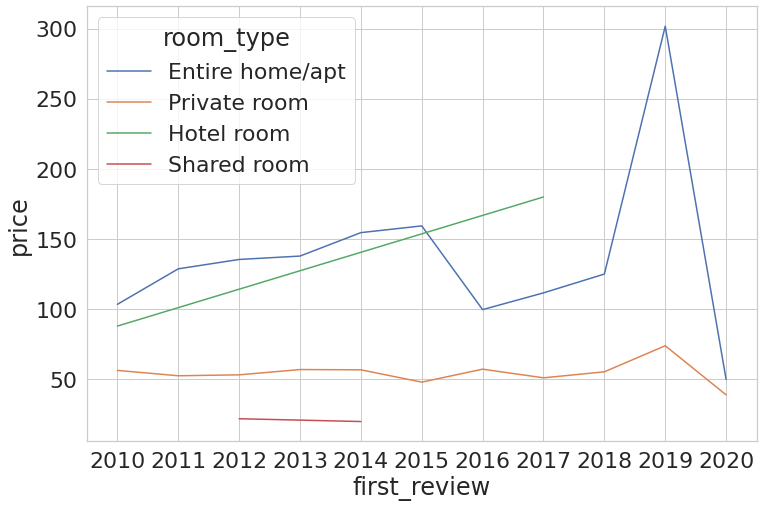

In [37]:
# Используя библиотеку seaborn и функцию lineplot, построим график динамики средних цен на жилье в зависимости от типа комнаты
plt.figure(figsize=(12, 8))
sns.lineplot(x='first_review',y='price',hue='room_type',data=df_8)